# Preparing Data

## Import Library and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The following describes the dataset columns:

```
crim - per capita crime rate by town
zn - proportion of residential land zoned for lots over 25,000 sq.ft.
indus - proportion of non-retail business acres per town.
chas - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
nox - nitric oxides concentration (parts per 10 million)
rm - average number of rooms per dwelling
age - proportion of owner-occupied units built prior to 1940
dis - weighted distances to five Boston employment centres
rad - index of accessibility to radial highways
tax - full-value property-tax rate per $10,000
ptratio - pupil-teacher ratio by town
black - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
lstat - % lower status of the population
medv - Median value of owner-occupied homes in $1000's
```



In [2]:
df = pd.read_csv('boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Split Data: train-validation-test

In [3]:
# Split train test
from sklearn.model_selection import train_test_split

x = df.drop(columns='medv')
y = df[['medv']]

# First splitting: pretrain and test
x_pretrain, x_test, y_pretrain, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Second splitting: train and validation
x_train, x_validation, y_train, y_validation = train_test_split(x_pretrain, y_pretrain, test_size=0.20, random_state=42)

## Multicollinear Check

In [4]:
# Calculating VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(x_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


There are several features with high VIF scores:
1.   nox (moderate multicollinearity)
2.   dis (moderate multicollinearity)
3.   rad (moderate multicollinearity)
4.   tax (moderate multicollinearity)

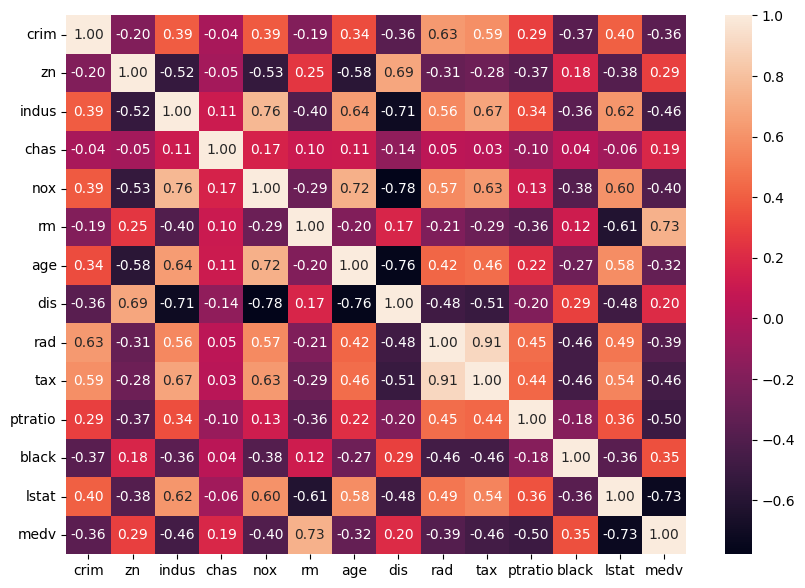

In [5]:
# Heatmap correlation
df_train = pd.concat([x_train, y_train], axis=1)
corr = df_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

The features with very strong correlation (>= 0.80): rad - tax with a correlation of 0.91. Therefore, we need to retain one of them, specifically the one with the highest correlation to the target variable.
*   retain tax
*   drop rad


Note: Although the variables nox and dis have VIF scores greater than 4, their correlation with other variables is not considered very high/strong. Therefore, in this case, it is not necessary to drop either or both of these variables.

In [6]:
x_train = x_train.drop(columns=['rad'])
x_validation = x_validation.drop(columns=['rad'])
x_test = x_test.drop(columns=['rad'])

# Choosing the Best Lambda

## Ridge Regression

### Train Multiple Models

In [7]:
from sklearn.linear_model import Ridge

# Define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# Fit the model (training)
ridge_reg_pointzeroone.fit(x_train.to_numpy(), y_train.to_numpy())
ridge_reg_pointone.fit(x_train.to_numpy(), y_train.to_numpy())
ridge_reg_one.fit(x_train.to_numpy(), y_train.to_numpy())
ridge_reg_ten.fit(x_train.to_numpy(), y_train.to_numpy())

Ridge(alpha=10, random_state=42)

### Find the Best Model (alpha)

In [8]:
from sklearn.metrics import mean_squared_error

# Calculating RMSE for each model
models = [ridge_reg_pointzeroone, ridge_reg_pointone, ridge_reg_one, ridge_reg_ten]
rmse_ridge = pd.DataFrame({
    'alphas': [0.01, 0.1, 1., 10],
    'rmse': [0.0, 0.0, 0.0, 0.0]})

for i in range(len(rmse_ridge)):
    y_predict_validation = models[i].predict(x_validation.to_numpy())
    rmse = np.sqrt(mean_squared_error(y_validation.to_numpy(), y_predict_validation))
    rmse_ridge.loc[i, 'rmse'] = rmse
rmse_ridge

,alphas,rmse
0,0.01,4.960677
1,0.10,4.949413
2,1.00,4.912351
3,10.00,4.871718


In [9]:
# Best Model
min_rmse_index = rmse_ridge['rmse'].idxmin()
print(f"The minimum RMSE is {rmse_ridge.loc[min_rmse_index, 'rmse']} with the alpha = {rmse_ridge.loc[min_rmse_index, 'alphas']} -> The best model")

The minimum RMSE is 4.871717983886228 with the alpha = 10.0 -> The best model


### Coefficients

In [10]:
ridge_best = models[min_rmse_index]

coef_df = pd.DataFrame({
    'feature':['intercept'] + x_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_[0]] + list(ridge_best.coef_)})
coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


**The established model:**


```
medv = 15.064666 - 0.071408*crim + 0.033030*zn - 0.067858*indus + 1.955801*chas - 1.568248*nox + 4.783168*rm - 0.011523*age - 1.260056*dis - 0.001976*tax - 0.697550*ptratio + 0.012729*black - 0.523827*lstat
```

**Based on the equations above, we can conclude two points:**
1.   There are several factors that contribute to a decline in the median value of homes (medv), including:
 *   High crime rates.
 *   A high percentage of land used for non-retail industrial businesses.
 *   High levels of nitric oxides (gases usually produced from combustion processes, such as vehicle engines, power plants, or industrial activities).
 *   A high proportion of older homes (built before 1940).
 *   Long distances between homes and the five Boston employment centers.
 *   High property tax rates.
 *   An imbalanced pupil-teacher ratio (more pupils than teachers).
 *   Homes located in areas with a high percentage of the population with low socio-economic status.
2.   Factors contributing to an increase in the median value of homes (medv) include:
 *   A higher percentage of land allocated for residential zones, indicating that the home is located in a neighborhood with many residential areas.
 *   Homes bordering the Charles River.
 *   Homes with a greater number of rooms.
 *   Homes located in areas with a high proportion of Black residents.


**Interpretation of each variable and its impact:**
*   Every increase of 1 unit in the per capita crime rate (crim) decreases the median value of homes (medv) by 0.071408 thousand dollar.
*   Every increase of 1 unit in the proportion of residential land zoned (zn) increases the median value of homes (medv) by 0.033030 thousand dollar.
*   Every increase of 1 unit in the proportion of non-retail business acres (indus) decreases the median value of homes (medv) by 0.067858 thousand dollar.
*   Homes bordering the Charles River (chas = 1) have a median value of homes (medv) that is 1.955801 thousand dollar higher compared to homes that do not border the Charles River (chas = 0).
*   Every increase of 1 unit in the nitric oxides concentration (nox) decreases the median value of homes (medv) by 1.568248 thousand dollar.
*   Every increase of 1 unit in the average number of rooms per dwelling (rm) increases the median value of homes (medv) by 4.783168 thousand dollar.
*   Every increase of 1 unit in the proportion of units built prior to 1940 (age) decreases the median value of homes (medv) by 0.011523 thousand dollar.
*   Every increase in the weighted distances to five Boston employment centers (dis) decreases the median value of homes (medv) by 1.260056 thousand dollar.
*   Every increase of 1 unit in the tax rate (tax) decreases the median value of homes (medv) by 0.001976 thousand dollar.
*   Every increase of 1 unit in the pupil-teacher ratio (ptratio) decreases the median value of homes (medv) by 0.697550 thousand dollar.
*   Every increase of 1 unit in the proportion of Black residents (black) increases the median value of homes (medv) by 0.012729 thousand dollar.
*   Every increase of 1 unit in the percentage of the population with low socio-economic status (lstat) decreases the median value of homes (medv) by 0.523827 thousand dollar.

## LASSO Regression

### Train Multiple Models

In [11]:
from sklearn.linear_model import Lasso

# Define the model
# 4 models with 4 different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# Fit the model (training)
lasso_reg_pointzeroone.fit(x_train.to_numpy(), y_train.to_numpy())
lasso_reg_pointone.fit(x_train.to_numpy(), y_train.to_numpy())
lasso_reg_one.fit(x_train.to_numpy(), y_train.to_numpy())
lasso_reg_ten.fit(x_train.to_numpy(), y_train.to_numpy())

Lasso(alpha=10, random_state=42)

### Find the Best Model (alpha)

In [12]:
from sklearn.metrics import mean_squared_error

# Calculating RMSE for each model
models = [lasso_reg_pointzeroone, lasso_reg_pointone, lasso_reg_one, lasso_reg_ten]
rmse_lasso = pd.DataFrame({
    'alphas': [0.01, 0.1, 1., 10],
    'rmse': [0.0, 0.0, 0.0, 0.0]})

for i in range(len(rmse_lasso)):
    y_predict_validation = models[i].predict(x_validation.to_numpy())
    rmse = np.sqrt(mean_squared_error(y_validation.to_numpy(), y_predict_validation))
    rmse_lasso.loc[i, 'rmse'] = rmse
rmse_lasso

,alphas,rmse
0,0.01,4.934106
1,0.10,4.907145
2,1.00,4.845856
3,10.00,5.426623


In [13]:
# Best Model
min_rmse_index = rmse_lasso['rmse'].idxmin()
print(f"The minimum RMSE is {rmse_lasso.loc[min_rmse_index, 'rmse']} with the alpha = {rmse_lasso.loc[min_rmse_index, 'alphas']} -> The best model")

The minimum RMSE is 4.845855910636398 with the alpha = 1.0 -> The best model


### Coefficients

In [14]:
lasso_best = models[min_rmse_index]

coef_df = pd.DataFrame({
    'feature':['intercept'] + x_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_[0]] + list(lasso_best.coef_)})
coef_df

,feature,coefficient
0,intercept,25.823435
1,crim,-0.041076
2,zn,0.025273
3,indus,-0.000000
4,chas,0.000000
5,nox,-0.000000
6,rm,2.504122
7,age,0.022055
8,dis,-0.599362
9,tax,-0.002994


**Notes**

The variables proportion of non-retail business acres (indus), location of the house relative to the Charles River (whether it borders the river or not) (chas), and nitric oxides concentration (nox) have coefficients of 0. This means that these variables are considered to have no significant influence on the median value of homes (medv) and, therefore, are excluded from the model.


**The established model:**


```
medv = 25.823435 - 0.041076*crim + 0.025273*zn + 2.504122*rm + 0.022055*age - 0.599362*dis - 0.002994*tax - 0.666222*ptratio + 0.011400*black - 0.712433*lstat
```

**Based on the equations above, we can conclude two points:**
1.   There are several factors that contribute to a decline in the median value of homes (medv), including:
 *   High crime rates.
 *   Long distances between homes and the five Boston employment centers.
 *   High property tax rates.
 *   An imbalanced pupil-teacher ratio (more pupils than teachers).
 *   Homes located in areas with a high percentage of the population with low socio-economic status.
2.   Factors contributing to an increase in the median value of homes (medv) include:
 *   A higher percentage of land allocated for residential zones, indicating that the home is located in a neighborhood with many residential areas.
 *   Homes with a greater number of rooms.
 *   A high proportion of older homes (built before 1940).
 *   Homes located in areas with a high proportion of Black residents.


**Interpretation of each variable and its impact:**
*   Every increase of 1 unit in the per capita crime rate (crim) decreases the median value of homes (medv) by 0.041076 thousand dollar.
*   Every increase of 1 unit in the proportion of residential land zoned (zn) increases the median value of homes (medv) by 0.025273 thousand dollar.
*   Every increase of 1 unit in the average number of rooms per dwelling (rm) increases the median value of homes (medv) by 2.504122 thousand dollar.
*   Every increase of 1 unit in the proportion of units built prior to 1940 (age) increases the median value of homes (medv) by 0.022055 thousand dollar.
*   Every increase in the weighted distances to five Boston employment centers (dis) decreases the median value of homes (medv) by 0.599362 thousand dollar.
*   Every increase of 1 unit in the tax rate (tax) decreases the median value of homes (medv) by 0.002994 thousand dollar.
*   Every increase of 1 unit in the pupil-teacher ratio (ptratio) decreases the median value of homes (medv) by 0.666222 thousand dollar.
*   Every increase of 1 unit in the proportion of Black residents (black) increases the median value of homes (medv) by 0.011400 thousand dollar.
*   Every increase of 1 unit in the percentage of the population with low socio-economic status (lstat) decreases the median value of homes (medv) by 0.712433 thousand dollar.

## Additional Insight

Here are several key points highlighted from the coefficient calculations and interpretations above:
1. In Ridge Regression, the variable age has a negative relationship with the median value of homes (medv), whereas in LASSO regression, the relationship is positive. This difference needs to be further reviewed from a business understanding perspective: Are older homes in the area indeed more appealing due to certain factors (e.g., architecture, uniqueness, better durability), or are they less appealing because of the potential for structural issues and other related factors?
2. There is an anomaly in the influence of the variable black (proportion of Black residents) on the median value of homes (medv), where it shows a positive relationship. This slightly differs from the majority of field evidence regarding racism issues in the United States. It is necessary to further cross-check whether racism issues in the region no longer exist and whether tolerance has increased. This would help determine whether the relationship between these variables in the model is accurate.

# Diagnostic Study

## Ridge Regression

### R-Square

In [15]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(x_train.to_numpy())
print('R-squared for training data is {}'.format(r2_score(y_train.to_numpy(), y_predict_train)))

R-squared for training data is 0.7485875263669821


The R-Square value in the Ridge Regression is 0.7485875263669821 or approximately 74.86%. This indicates that the twelve independent variables/features included in the model are able to explain 74.86% of the variability in the dependent variable (medv/median value of homes). The remaining 25.14% is explained by other variables outside the model.

### Assumption Check

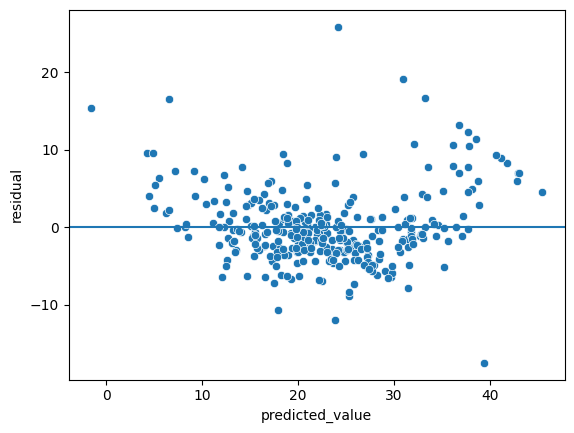

In [16]:
# Calculate residuals
residual = y_train.to_numpy()[:, 0] - y_predict_train

# Prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual})

# Residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption Checks:
*   Linear relationship: Fulfilled. The horizontal line at y=0 adequately represents the overall distribution of residual points.
*   Variance stability: Not fulfilled. Variance is more pronounced at the beginning and end of the data.
*   Independent residuals: Not fulfilled. The residual points appear to form a curved (non-linear) pattern.

### Model Evaluation

In [17]:
# Calculating error of Data Training

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on train data
y_predict_train = ridge_best.predict(x_train.to_numpy())

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train.to_numpy(), y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train.to_numpy(), y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train.to_numpy(), y_predict_train)))

RMSE for training data is 4.77864036104011
MAE for training data is 3.3776762058865626
MAPE for training data is 0.168680736633595


In [18]:
# Calculating error of Data Testing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on test data
y_predict_test = ridge_best.predict(x_test.to_numpy())

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test.to_numpy(), y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test.to_numpy(), y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test.to_numpy(), y_predict_test)))

RMSE for testing data is 5.158908333657057
MAE for testing data is 3.244481645704498
MAPE for testing data is 0.17618402626767926


The evaluation results of the model indicate that the RMSE, MAE, and MAPE values for the training data and testing data do not show significant differences (only slightly higher), suggesting that the selected model has been proven to be well-suited.

## LASSO Regression

### R-Square

In [19]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(x_train.to_numpy())
print('R-squared for training data is {}'.format(r2_score(y_train.to_numpy(), y_predict_train)))

R-squared for training data is 0.7056815963218595


The R-Square value in the LASSO Regression is 0.7056815963218595 or approximately 70.57%. This indicates that the nine independent variables/features included in the model are able to explain 70.57% of the variability in the dependent variable (medv/median value of homes). The remaining 29.43% is explained by other variables outside the model.

### Assumption Check

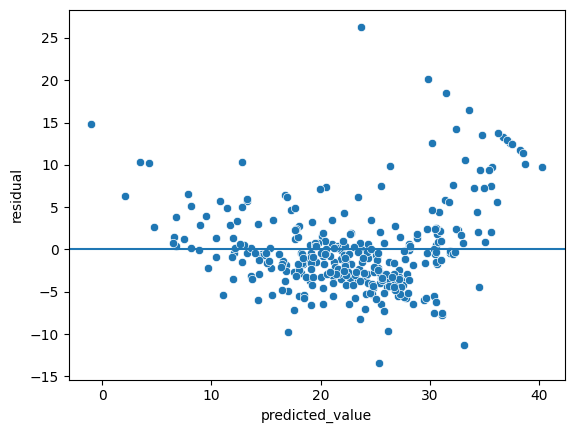

In [20]:
# Calculate residuals
residual = y_train.to_numpy()[:, 0] - y_predict_train

# Prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual})

# Residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption Checks:
*   Linear relationship: Not fulfilled. The residual points are not evenly distributed around the y=0 line (more data below the y=0 line).
*   Variance stability: Not fulfilled. Variance is more pronounced at the beginning and end of the data.
*   Independent residuals: Not fulfilled. The residual points appear to form a curved (non-linear) pattern.

### Model Evaluation

In [21]:
# Calculating error of Data Training

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on train data
y_predict_train = lasso_best.predict(x_train.to_numpy())

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train.to_numpy(), y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train.to_numpy(), y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train.to_numpy(), y_predict_train)))

RMSE for training data is 5.170346463296143
MAE for training data is 3.6858416211465084
MAPE for training data is 0.1749128202363825


In [22]:
# Calculating error of Data Testing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on test data
y_predict_test = lasso_best.predict(x_test.to_numpy())

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test.to_numpy(), y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test.to_numpy(), y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test.to_numpy(), y_predict_test)))

RMSE for testing data is 5.125494212319777
MAE for testing data is 3.3980507105960682
MAPE for testing data is 0.17856606338732206


The evaluation results of the model indicate that the RMSE, MAE, and MAPE values for the training data and testing data do not show significant differences, and are even lower for the testing data, suggesting that the selected model has been proven to be well-suited.